In [1]:
import pandas as pd

In [191]:
from math import sqrt
from ProjectTools import OpenBeds

dry = True

def filter_on_depth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*sqrt(average))]
    return df

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_hmc_df = filter_on_depth(nano_hmc_df)

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    nano_hmc_df = filter_on_depth(nano_hmc_df)

In [196]:
from pybedtools import BedTool

ref_features = BedTool('./feature_references/fig4_features.bed')
cgi_features = BedTool('./feature_references/mm39_CGI_features.bed')

In [197]:
def makeIntersect(df, ref):
    return  BedTool.intersect(BedTool.from_dataframe(df), ref, wb=True).to_dataframe(
        names=[*nano_mc_df.columns, ".1", ".2", ".3", "feature_name", "feature_type"]).drop(columns=[".1", ".2", ".3"])

In [198]:
mc_genic_df = makeIntersect(pd.concat([nano_mc_df, wgbs_df]), ref_features)
hmc_genic_df = makeIntersect(pd.concat([nano_hmc_df, tab_df]), ref_features)

In [234]:
nano_mc_pie = pd.DataFrame(
    mc_genic_df.loc[(mc_genic_df["percentMeth"] > 0) & (mc_genic_df["method"].str.contains("Nanopore"))].groupby(
    ["feature_type", "method"], as_index=True)["feature_type"].count()).rename(
    columns={"feature_type" : "count"}).reset_index()

nano_hmc_pie = pd.DataFrame(
    hmc_genic_df.loc[(hmc_genic_df["percentMeth"] > 0) & (hmc_genic_df["method"].str.contains("Nanopore"))].groupby(
    ["feature_type", "method"], as_index=True)["feature_type"].count()).rename(
    columns={"feature_type" : "count"}).reset_index()

wgbs_mc_pie = pd.DataFrame(
    mc_genic_df.loc[(mc_genic_df["percentMeth"] > 0) & (mc_genic_df["method"].str.contains("Nanopore") == False)].groupby(
    ["feature_type", "method"], as_index=True)["feature_type"].count()).rename(
    columns={"feature_type" : "count"}).reset_index()

tab_hmc_pie = pd.DataFrame(
    hmc_genic_df.loc[(hmc_genic_df["percentMeth"] > 0) & (hmc_genic_df["method"].str.contains("Nanopore")  == False)].groupby(
    ["feature_type", "method"], as_index=True)["feature_type"].count()).rename(
    columns={"feature_type" : "count"}).reset_index()

In [229]:
mc_gene_df = mc_genic_df.groupby(["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(["feature_type", "method"])["percentMeth"].mean().reset_index()
hmc_gene_df = hmc_genic_df.groupby(["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(["feature_type", "method"])["percentMeth"].mean().reset_index()
gene_df = pd.concat([mc_gene_df, hmc_gene_df])
# gene_df = gene_df.loc[gene_df["feature_type"] != "Enhancer"]

gene_df["feature_type"] = pd.Categorical(gene_df["feature_type"], ["Promoter", "5UTR", "Exon", "Intron", "3UTR", "Intergenic", "Enhancer"])

In [230]:
mc_cgi = makeIntersect(
    pd.concat([nano_mc_df, wgbs_df]), cgi_features).groupby(
    ["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(
    ["feature_type", "method"])["percentMeth"].mean().reset_index()
hmc_cgi_df = makeIntersect(
    pd.concat([nano_hmc_df, tab_df]), cgi_features).groupby(
    ["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(
    ["feature_type", "method"])["percentMeth"].mean().reset_index()

cgi_df = pd.concat([mc_cgi, hmc_cgi_df])
cgi_df["feature_type"] = pd.Categorical(cgi_df["feature_type"], ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"])

/tmp/ipykernel_1824106/3351954517.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


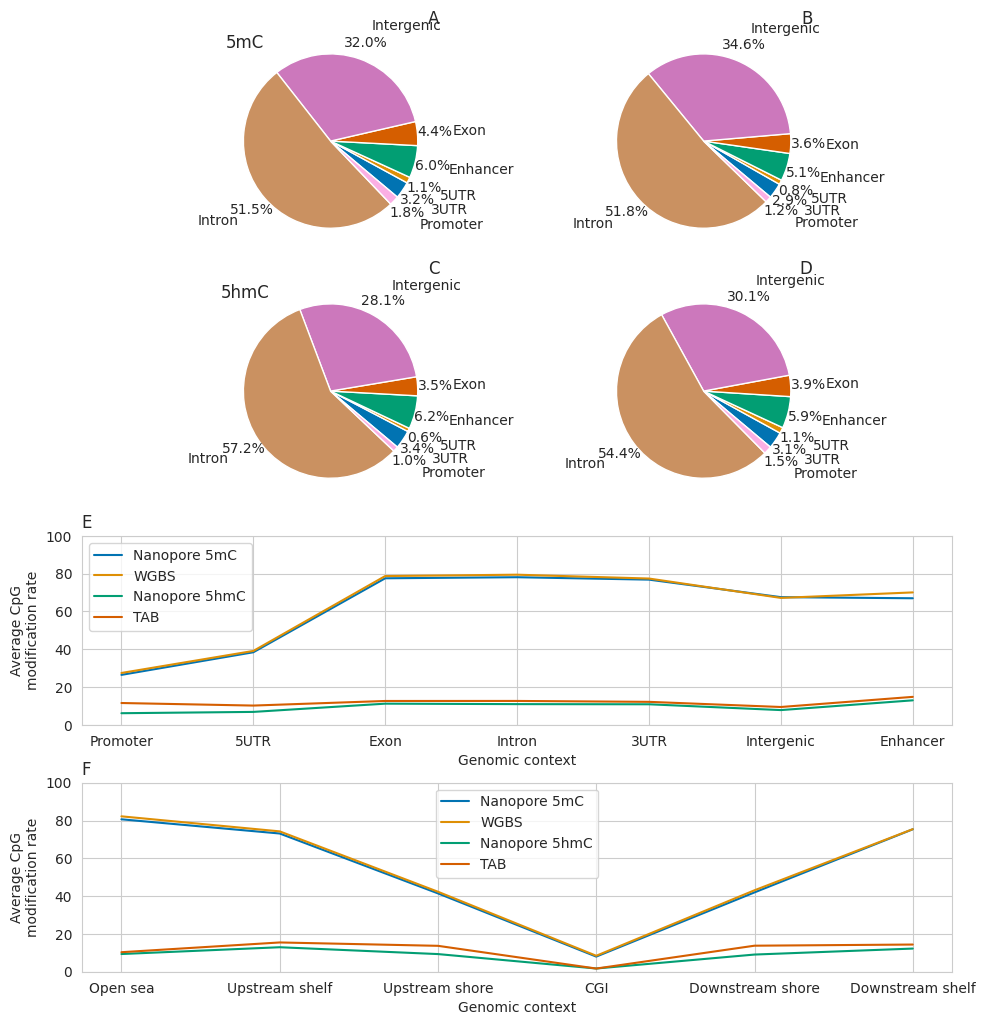

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(3, 2, fig, height_ratios=(2, 2, 4))

fig1 = fig.add_subfigure(gs[0, :])
fig1.suptitle("5mC", x=0.25)
gs1 = GridSpec(1, 2, fig1, wspace=-0.25)

ax1 = fig1.add_subplot(gs1[0, 0])
ax1.pie(
    wgbs_mc_pie["count"], 
    labels=nano_mc_pie["feature_type"], 
    autopct='%1.1f%%', pctdistance=1.20, labeldistance=1.40, startangle=-40, rotatelabels=False)
ax1.set_title("A", loc="right")

ax2 = fig1.add_subplot(gs1[0, 1])
ax2.pie(
    nano_mc_pie["count"], 
    labels=nano_hmc_pie["feature_type"], 
    autopct='%1.1f%%', pctdistance=1.20, labeldistance=1.40, startangle=-40, rotatelabels=False)
ax2.set_title("B", loc="right")

fig2 = fig.add_subfigure(gs[1, :])
fig2.suptitle("5hmC", x=0.25)
gs2 = GridSpec(1, 2, fig2, wspace=-0.25)

ax3 = fig2.add_subplot(gs2[0, 0])
ax3.pie(
    tab_hmc_pie["count"], 
    labels=nano_mc_pie["feature_type"], 
    autopct='%1.1f%%', pctdistance=1.20, labeldistance=1.40, startangle=-40, rotatelabels=False)
ax3.set_title("C", loc="right")


ax4 = fig2.add_subplot(gs2[0, 1])
ax4.pie(
    nano_hmc_pie["count"], 
    labels=nano_hmc_pie["feature_type"], 
    autopct='%1.1f%%', pctdistance=1.20, labeldistance=1.40, startangle=-40, rotatelabels=False)
ax4.set_title("D", loc="right")

fig3 = fig.add_subfigure(gs[2, :])
gs3 = GridSpec(2, 1, fig3)

ax5 = fig3.add_subplot(gs3[0, :])
sns.lineplot(gene_df, x="feature_type", y="percentMeth", hue="method", ax=ax5)
ax5.set_ylim(0, 100)
ax5.set_xlabel("Genomic context")
ax5.set_ylabel("Average CpG\nmodification rate")
sns.move_legend(ax5, "upper left", title=None)
ax5.set_title("E", loc="left")

ax6 = fig3.add_subplot(gs3[1, :])
sns.lineplot(cgi_df, x="feature_type", y="percentMeth", hue="method", ax=ax6)
ax6.set_ylim(0, 100)
ax6.set_xlabel("Genomic context")
ax6.set_ylabel("Average CpG\nmodification rate")
sns.move_legend(ax6, "upper center", title=None)
ax6.set_title("F", loc="left")

fig.tight_layout()